In [38]:
from mmcv import Config
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pycocotools.coco import COCO

import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

import random

## Model Config

In [2]:
model_cfg = \
"htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco_no_seg"

# load config.
cfg = Config.fromfile(os.path.join("save_dir", model_cfg, "configs.py"))

## Model Load

In [3]:
# checkpoint
checkpoint_path = os.path.join(cfg.work_dir, "best_bbox_mAP_50.pth")

model = build_detector(cfg.model, test_cfg=cfg.get("test_cfg"))
checkpoint = load_checkpoint(model, checkpoint_path, map_location="cpu")

valid_dataset = build_dataset(cfg.data.val)
test_dataset = build_dataset(cfg.data.test)

model.CLASSES = test_dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

Use load_from_local loader
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## Inference on validation data

In [4]:
data_loader = build_dataloader(valid_dataset, samples_per_gpu=1, workers_per_gpu=cfg.data.workers_per_gpu, dist=False, shuffle=False)

valid_coco = COCO("../input/data/val.json")
valid_output = single_gpu_test(model, data_loader, show_score_thr=0.05)

loading annotations into memory...
Done (t=1.07s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 655/655, 5.5 task/s, elapsed: 119s, ETA:     0s

## Inference on test data

In [5]:
data_loader = build_dataloader(test_dataset, samples_per_gpu=1, workers_per_gpu=cfg.data.workers_per_gpu, dist=False, shuffle=False)

test_coco = COCO("../input/data/test.json")
test_output = single_gpu_test(model, data_loader, show_score_thr=0.05)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 837/837, 5.6 task/s, elapsed: 150s, ETA:     0s

## Define for helper function

In [81]:
class_num = 11
class_name = classes = (
    "UNKNOWN", "General trash", "Paper", "Paper pack", 
    "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", 
    "Battery", "Clothing"
)
COLORS = [
    (204,24,30),
    (39,147,232),
    (85,153,0),
    (102,102,102),
    (27,133,184),
    (90,82,85),
    (85,158,131),
    (174,90,65),
    (195,203,113),
    (243,119,54),
    (184,167,234)
]

def bbox_on_image(image, bboxes):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    for cls_idx in range(class_num):
        for cls_bbox in bboxes[cls_idx]:
            cls_name = class_name[cls_idx]
            cls_score = cls_bbox[-1]
            xmin, ymin, xmax, ymax = map(lambda x: int(x), cls_bbox[:4])
            if cls_score > 0.05:
                draw.rectangle(((xmin, ymin), (xmax, ymax)), outline=COLORS[cls_idx])
                draw.text((xmin, ymin), f"{cls_name}\n{cls_score:4f}", fill="#000000")
    
    return image

def get_gt_bboxes(anns):
    gt_bboxes = [[] for _ in range(class_num)]
    
    for ann in anns:
        cls_id = ann["category_id"]
        xmin, ymin, w, h = [int(v) for v in ann["bbox"]]
        xmax, ymax = xmin + w, ymin + h
        
        gt_bboxes[cls_id].append([xmin, ymin, xmax, ymax, 1.0])
        
    return gt_bboxes

## Compare predicted image with ground truth

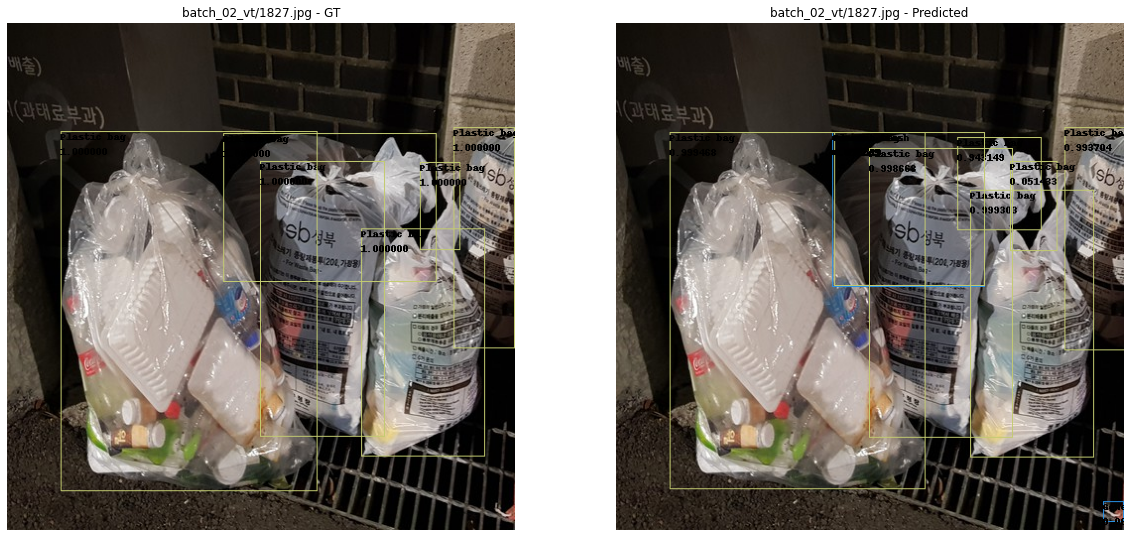

In [104]:
idx = random.randint(0, 655)

image = cv2.imread(os.path.join("../input/data", valid_coco.load_imgs(idx)[0]["file_name"]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.copy()

gt_bboxes = get_gt_bboxes(valid_coco.load_anns(valid_coco.get_ann_ids(idx)))
pred_bboxes = valid_output[idx][0]

# for cls_idx in range(class_num):
#     for cls_bbox in pred_bboxes[cls_idx]:
#         cls_name = class_name[cls_idx]
#         cls_score = cls_bbox[-1]
#         print(f"{cls_name} : {cls_score}")


gt_image = bbox_on_image(image, gt_bboxes)
pred_image = bbox_on_image(image, pred_bboxes)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title(test_coco.load_imgs(idx)[0]["file_name"] + " - GT")
plt.axis("off")
plt.imshow(gt_image)

plt.subplot(1, 2, 2)
plt.title(test_coco.load_imgs(idx)[0]["file_name"] + " - Predicted")
plt.axis("off")
plt.imshow(pred_image)

plt.show()

## Draw predicted test image

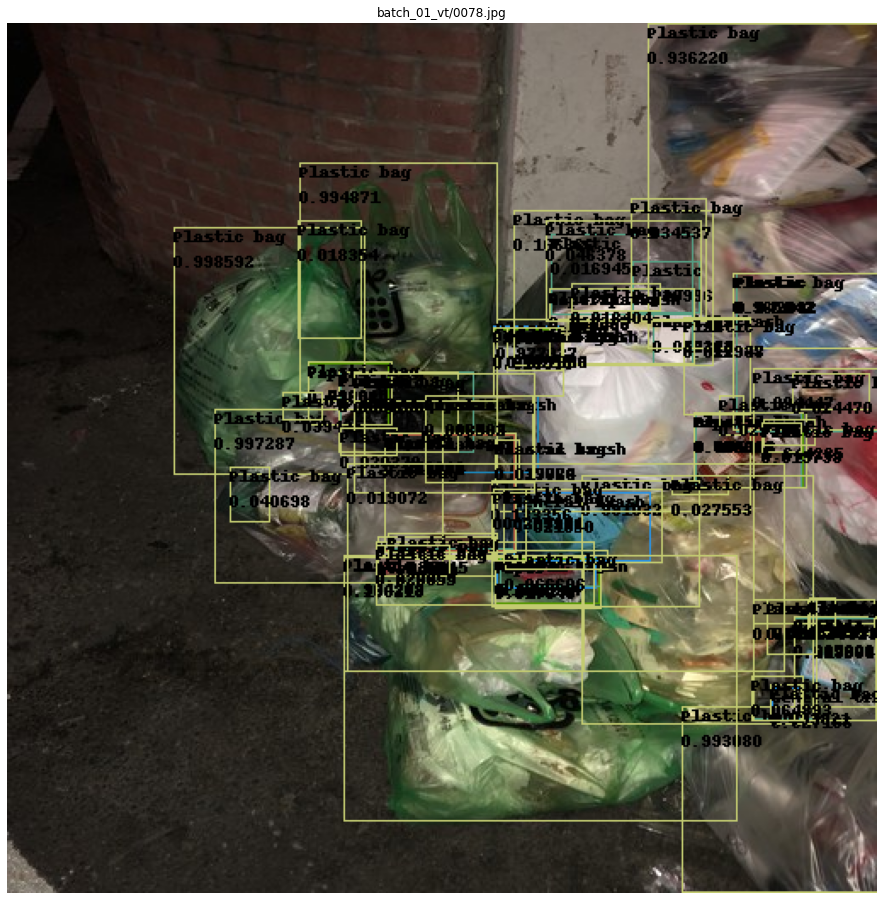

In [26]:
idx = 6

image = cv2.imread(os.path.join("../input/data", test_coco.load_imgs(idx)[0]["file_name"]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.copy()
bboxes = test_output[idx][0]

bboxed_image = bbox_on_image(image, bboxes)

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title(test_coco.load_imgs(idx)[0]["file_name"])
plt.imshow(bboxed_image)
plt.show()